# Illustrating Distribution with Plotnine Package

In [12]:
# Loading Libraries
import polars as pl
import polars.selectors as cs
from plotnine import *
from mizani.labels import label_number

In [8]:
census_raw = pl.read_csv(url, null_values='NA')
print(census_raw)

shape: (453, 10)
┌───────────────┬─────────────────────────────────┬───────────────────┬──────────┬───┬──────────┬───────┬─────────┬────────┐
│ Region        ┆ Region Name                     ┆ Region - RegionId ┆ Variable ┆ … ┆ Age Name ┆ Scale ┆ Units   ┆ 2008   │
│ ---           ┆ ---                             ┆ ---               ┆ ---      ┆   ┆ ---      ┆ ---   ┆ ---     ┆ ---    │
│ str           ┆ str                             ┆ str               ┆ str      ┆   ┆ str      ┆ str   ┆ str     ┆ i64    │
╞═══════════════╪═════════════════════════════════╪═══════════════════╪══════════╪═══╪══════════╪═══════╪═════════╪════════╡
│ KN.A2         ┆ Upper Nile                      ┆ SS-NU             ┆ KN.B2    ┆ … ┆ Total    ┆ units ┆ Persons ┆ 964353 │
│ KN.A2         ┆ Upper Nile                      ┆ SS-NU             ┆ KN.B2    ┆ … ┆ 0 to 4   ┆ units ┆ Persons ┆ 150872 │
│ KN.A2         ┆ Upper Nile                      ┆ SS-NU             ┆ KN.B2    ┆ … ┆ 5 to 9   ┆ units ┆ Pe

In [23]:
# Let's import our custom function censuspy as cy
import censuspy as cy
census = (
    cy.tweak_census(
    census_raw, 
    grouping_cols=['former_region', 'state', 'gender', 'category'], 
    condition=~((pl.col('gender') == 'Total') | (pl.col('category') == 'Total')) 
    )
)

# inspect the first 5 rows
print(census)

shape: (140, 5)
┌────────────────────────┬────────────────────────┬────────┬──────────────┬────────┐
│ former_region          ┆ state                  ┆ gender ┆ category     ┆ total  │
│ ---                    ┆ ---                    ┆ ---    ┆ ---          ┆ ---    │
│ str                    ┆ str                    ┆ str    ┆ str          ┆ i64    │
╞════════════════════════╪════════════════════════╪════════╪══════════════╪════════╡
│ Greater Upper Nile     ┆ Jonglei                ┆ Male   ┆ 0-14         ┆ 338443 │
│ Greater Upper Nile     ┆ Jonglei                ┆ Female ┆ 0-14         ┆ 263646 │
│ Greater Equatoria      ┆ Central Equatoria      ┆ Male   ┆ 0-14         ┆ 242247 │
│ Greater Upper Nile     ┆ Upper Nile             ┆ Male   ┆ 0-14         ┆ 237461 │
│ Greater Bahr el Ghazal ┆ Warrap                 ┆ Male   ┆ 0-14         ┆ 230854 │
│ …                      ┆ …                      ┆ …      ┆ …            ┆ …      │
│ Greater Bahr el Ghazal ┆ Lakes                 

In [24]:
age = (
    census
    .group_by('category')
    .agg(total=pl.col('total').sum())
    .sort('total', descending=True)
    .with_columns(labels=(pl.col('total') / 1_000_000).round(2))
)

# inspect the summary
print(age)

shape: (7, 3)
┌──────────────┬─────────┬────────┐
│ category     ┆ total   ┆ labels │
│ ---          ┆ ---     ┆ ---    │
│ str          ┆ i64     ┆ f64    │
╞══════════════╪═════════╪════════╡
│ 0-14         ┆ 3659337 ┆ 3.66   │
│ 15-24        ┆ 1628835 ┆ 1.63   │
│ 25-34        ┆ 1234926 ┆ 1.23   │
│ 35-44        ┆ 815517  ┆ 0.82   │
│ 45-54        ┆ 473365  ┆ 0.47   │
│ 55-64        ┆ 237426  ┆ 0.24   │
│ 65 and above ┆ 211084  ┆ 0.21   │
└──────────────┴─────────┴────────┘
shape: (7, 3)
┌──────────────┬─────────┬────────┐
│ category     ┆ total   ┆ labels │
│ ---          ┆ ---     ┆ ---    │
│ str          ┆ i64     ┆ f64    │
╞══════════════╪═════════╪════════╡
│ 0-14         ┆ 3659337 ┆ 3.66   │
│ 15-24        ┆ 1628835 ┆ 1.63   │
│ 25-34        ┆ 1234926 ┆ 1.23   │
│ 35-44        ┆ 815517  ┆ 0.82   │
│ 45-54        ┆ 473365  ┆ 0.47   │
│ 55-64        ┆ 237426  ┆ 0.24   │
│ 65 and above ┆ 211084  ┆ 0.21   │
└──────────────┴─────────┴────────┘


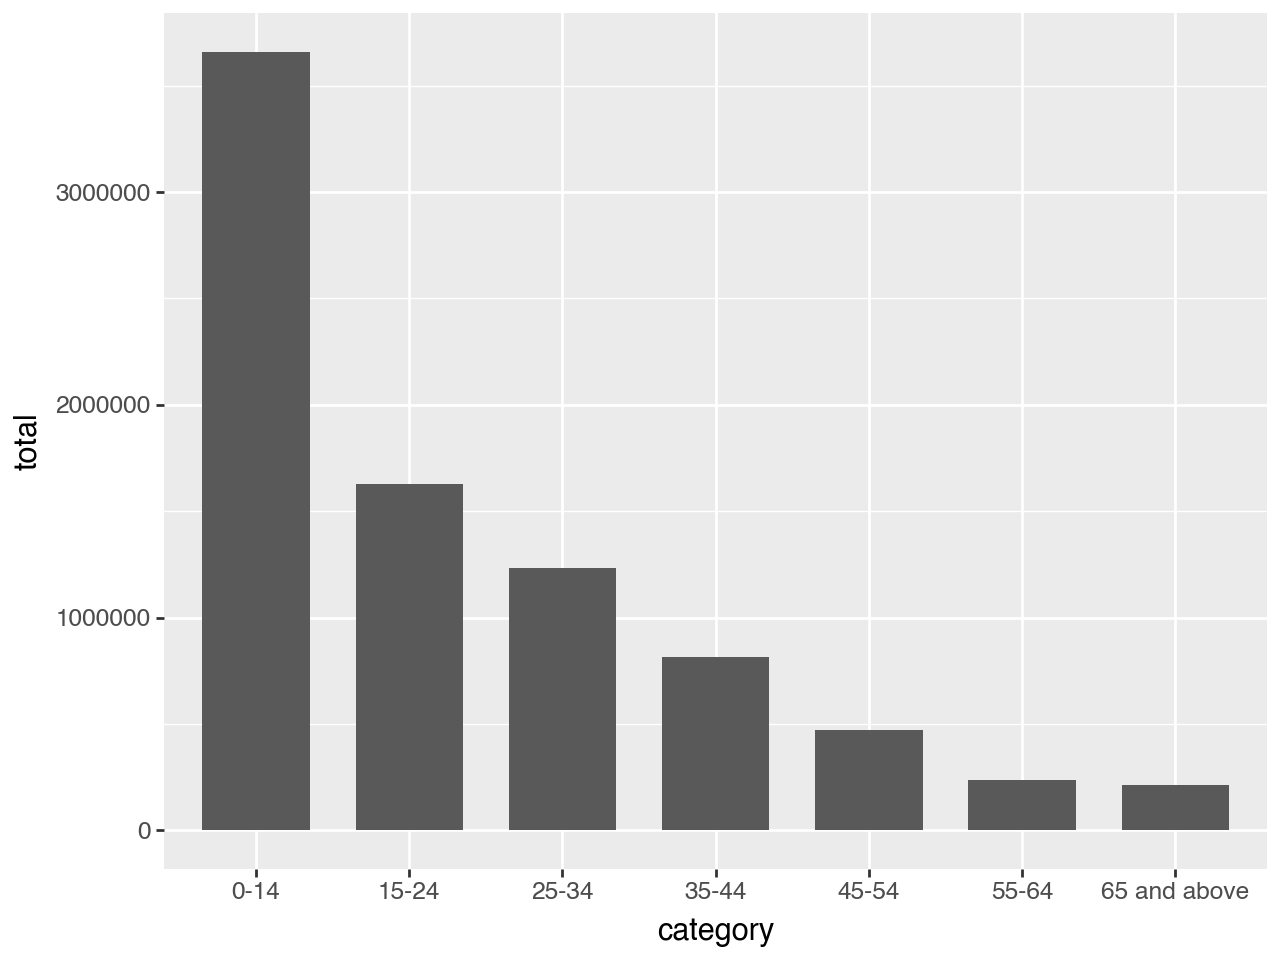

In [17]:
# Visualize the 2008 South Sudan Census by Former Region

(
    ggplot(age, aes('category', 'total'))
    + geom_col(stat='identity', width=0.7, show_legend=False) 
)

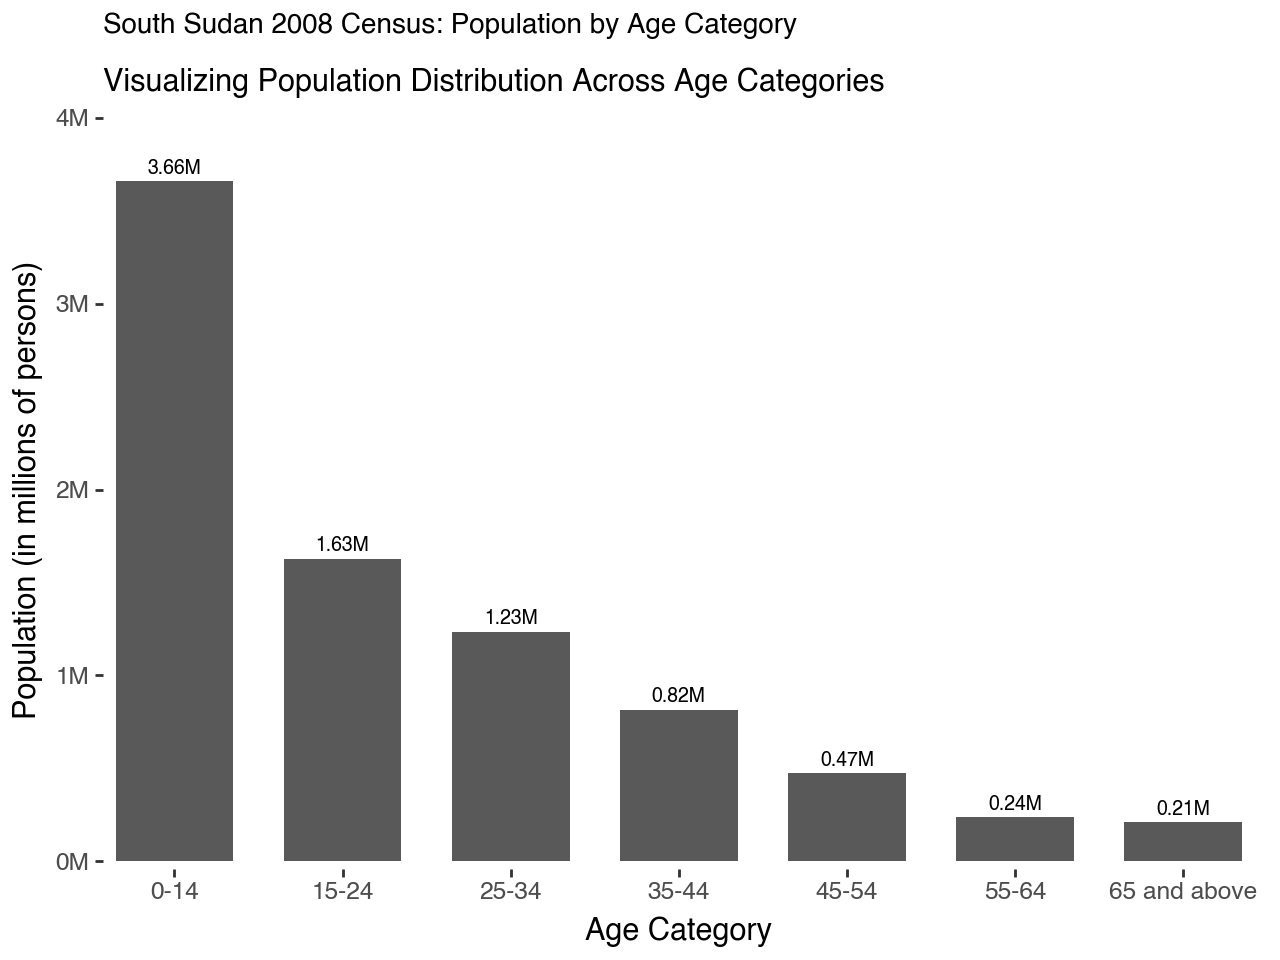

In [25]:
# Visualize the 2008 South Sudan Census by Former Region
(
    ggplot(age, aes('category', 'total'))
    + geom_col(stat='identity', width=0.7) 
    + geom_text(aes(label='labels'), format_string='{}M', nudge_y=70_000, size=7)
    + scale_y_continuous(
        limits=(0, 4_000_000), 
        expand=(0.01, 0.01),
        labels=label_number(scale=1e-6, suffix='M')
    )
    + scale_x_discrete(expand=(0.01, 0.01))
    + theme_tufte() 
    + labs(
        x='Age Category',
        y='Population (in millions of persons)',
        title='South Sudan 2008 Census: Population by Age Category',
        subtitle='Visualizing Population Distribution Across Age Categories'
    )
    + theme(
        plot_title=element_text(size=10, ha='left', margin={'t': 15, 'b': 10}),
    )
)

In [19]:
gender = (
    census
    .group_by(['state', 'gender'], maintain_order=True)
    .agg(total=pl.col('total').sum())
    .sort('total', 'state', 'gender', descending=True)
    .with_columns(labels=(pl.col('total') / 1_000_000).round(2))
)

# inspect the summary
print(gender)

shape: (20, 4)
┌────────────────────────┬────────┬────────┬────────┐
│ state                  ┆ gender ┆ total  ┆ labels │
│ ---                    ┆ ---    ┆ ---    ┆ ---    │
│ str                    ┆ str    ┆ i64    ┆ f64    │
╞════════════════════════╪════════╪════════╪════════╡
│ Jonglei                ┆ Male   ┆ 734327 ┆ 0.73   │
│ Jonglei                ┆ Female ┆ 624275 ┆ 0.62   │
│ Central Equatoria      ┆ Male   ┆ 581722 ┆ 0.58   │
│ Upper Nile             ┆ Male   ┆ 525430 ┆ 0.53   │
│ Central Equatoria      ┆ Female ┆ 521835 ┆ 0.52   │
│ …                      ┆ …      ┆ …      ┆ …      │
│ Western Equatoria      ┆ Female ┆ 300586 ┆ 0.3    │
│ Unity                  ┆ Male   ┆ 300247 ┆ 0.3    │
│ Unity                  ┆ Female ┆ 285554 ┆ 0.29   │
│ Western Bahr el Ghazal ┆ Male   ┆ 177040 ┆ 0.18   │
│ Western Bahr el Ghazal ┆ Female ┆ 156391 ┆ 0.16   │
└────────────────────────┴────────┴────────┴────────┘
shape: (20, 4)
┌────────────────────────┬────────┬────────┬────────

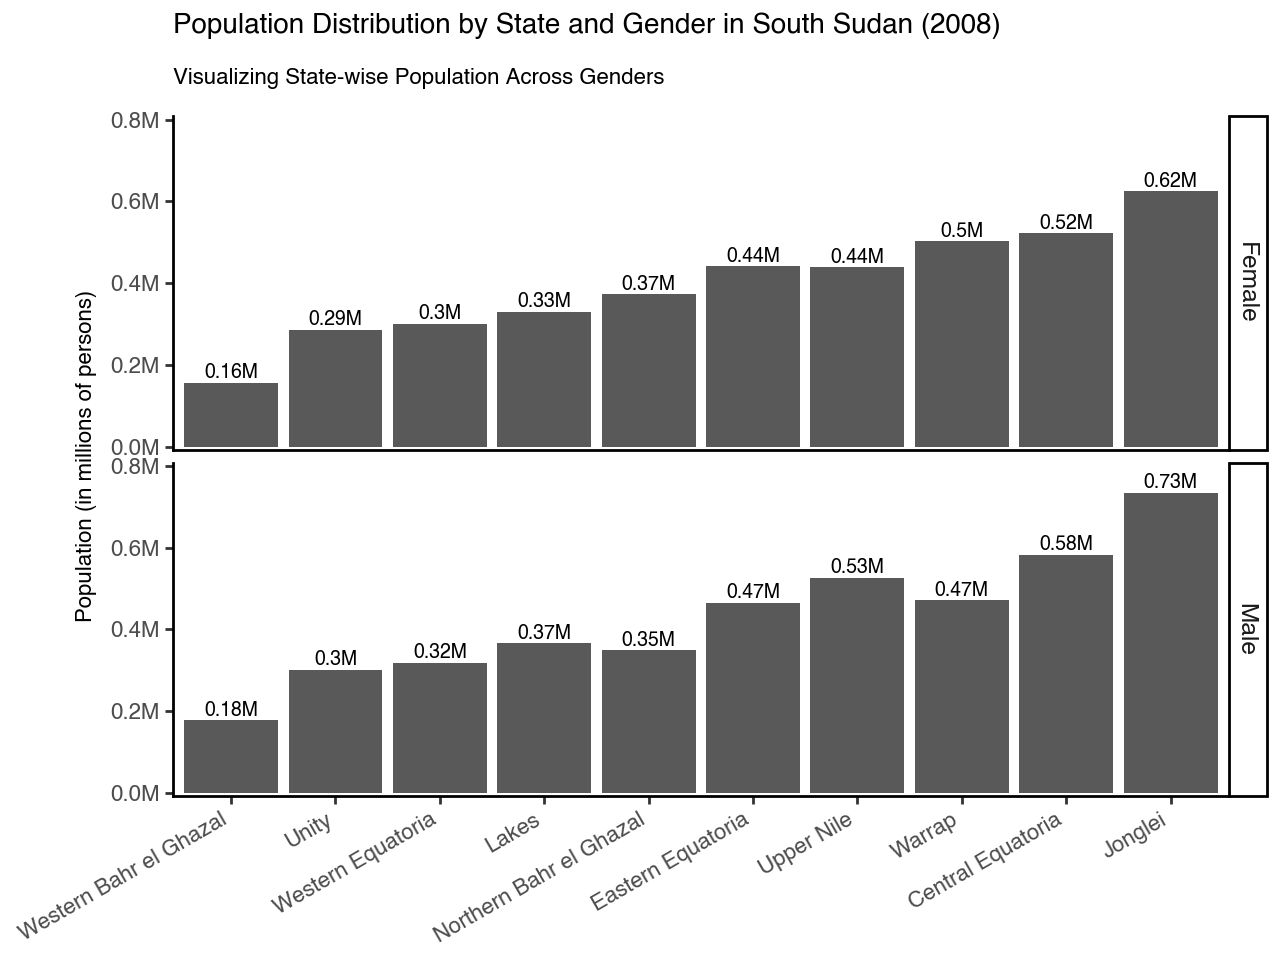

In [27]:

(
    ggplot(gender, aes('reorder(state, total)', 'total'))
    + geom_col(position='dodge')
    + geom_text(aes(label='labels'), format_string='{}M', nudge_y=25_000, size=7)
    + scale_x_discrete(expand=(0.01, 0.01))
    + scale_y_continuous(
        limits=(0, 800_000), 
        expand=(0.01, 0.01),
        labels=label_number(scale=1e-6, suffix='M')
    )
    + facet_grid('gender', scales='free_y')
    + theme_classic()
    + labs(
        x='',
        y='Population (in millions of persons)',
        title='Population Distribution by State and Gender in South Sudan (2008)',
        subtitle='Visualizing State-wise Population Across Genders'
    )
    + theme(
        plot_title=element_text(size=10, margin={'t': 10, 'b': 10}, ha='left'),
        plot_subtitle=element_text(size=8, margin={'b': 10}, ha='left'),
        axis_text=element_text(size=8),
        axis_text_x=element_text(rotation=30, hjust=1),
        axis_title_y=element_text(size=8)
    )
)

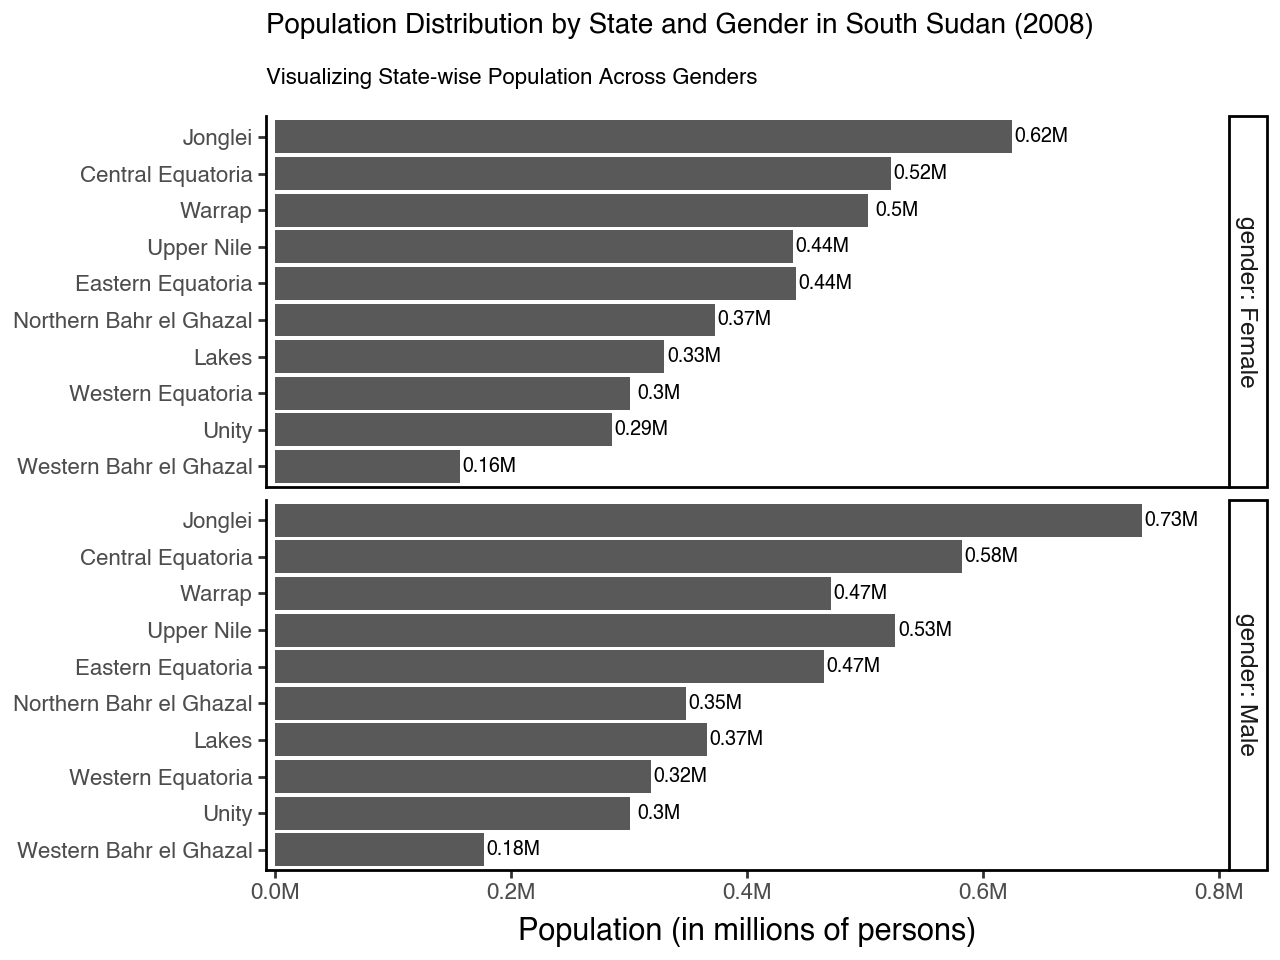

In [21]:

(
    ggplot(gender, aes('reorder(state, total)', 'total'))
    + geom_col(position='dodge')
    + geom_text(aes(label='labels'), format_string='{}M', nudge_y=25_000, size=7)
    + scale_x_discrete(expand=(0.01, 0.01))
    + scale_y_continuous(
        limits=(0, 800_000), 
        expand=(0.01, 0.01),
        labels=label_number(scale=1e-6, suffix='M')
    )
    + facet_grid('gender', scales='free_y', labeller='label_both')
    + coord_flip()
    + theme_classic()
    + labs(
        x='',
        y='Population (in millions of persons)',
        title='Population Distribution by State and Gender in South Sudan (2008)',
        subtitle='Visualizing State-wise Population Across Genders'
    )
    + theme(
        plot_title=element_text(size=10, margin={'t': 10, 'b': 10}),
        plot_subtitle=element_text(size=8, margin={'b': 10}),
        axis_text=element_text(size=8),
        axis_title_y=element_text(size=8)
    )
)